# **Methods for WWA synthesis & plotting**

- some modifications still needed to handle logs

In [319]:
import pandas as pd
import numpy as np
from scipy.optimize import brent

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [291]:
df_in = pd.read_table("minisynth_in.txt", skiprows = 1, sep = " ", names = ["y0","y1","est", "lower", "upper", "ci", "model", "m2", "m3"])

In [292]:
obs_in = df_in.iloc[:3]
models_in = df_in.iloc[3:]

In [293]:
def model_mean(models, sig_mod = 0):

    # calculate weight for each model (based on width of confidence interval)
    w = 1/((models.upper - models.lower)**2 + (2*sig_mod)**2)
    w1 = sum(w)
    
    s1 = sum(models.est * w) / w1
    
    # inner bounds (coloured box, internal variability only)
    lower = np.sqrt(sum((w*(models.est - models.lower))**2)) / w1
    upper = np.sqrt(sum((w*(models.est - models.upper))**2)) / w1
    
    # outer bounds(white box, includes representation error via sig_mod)
    l_wb = np.sqrt(lower**2 + sig_mod**2)
    u_wb = np.sqrt(upper**2 + sig_mod**2)
    
    return pd.Series({"est" : s1,
                      "lower" : s1 - lower,
                      "upper" : s1 + upper,
                      "l_wb" : s1 - l_wb,
                      "u_wb" : s1 + u_wb})
    

In [294]:
def model_chi2(models_in, sig_mod = 0):

    # get best estimate using current value of sig_mod
    s1 = model_mean(models, sig_mod)["est"]
    
    # identify whether to use upper or lower bound to compute chi^2
    bounds = pd.Series([r.lower if r.est > s1 else r.upper for k,r in models.iterrows()], index=models.index)
    
    # compute chi^2
    chi2 = sum((models.est - s1)**2 / ((models.est - bounds)**2 + sig_mod**2))
    chi2 = chi2 * 4 # transform to give 95%~2sigma CIs
    
    return chi2

In [309]:
cx_format = False
def synthesis(obs_in, models_in, cx_format = False):

    # and now, the actual synthesis
    
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ## OBSERVATIONS
    # get mean of intervals to estimate natural variability component
    obs_synth = obs_in[["est", "lower", "upper"]].mean(axis = 0)
    
    # compute representation error from scatter of mean
    nobs = len(obs_in)
    sig_obs = np.sqrt(sum((obs_in.est - obs_synth["est"])**2) / (nobs-1))
    
    # add representation error to observations
    obs_out = pd.merge(obs_in, 
                      pd.DataFrame({"l_wb" : obs_in.est - np.sqrt((obs_in.est - obs_in.lower)**2 + sig_obs**2),
                                    "u_wb" : obs_in.est + np.sqrt((obs_in.est - obs_in.upper)**2 + sig_obs**2)}).set_index(obs_in.index),
                      left_index = True, right_index = True)
    
    # add representation error to synthesis
    obs_synth["l_wb"] = obs_synth.est - np.sqrt((obs_synth.est - obs_synth.lower)**2 + sig_obs**2)
    obs_synth["u_wb"] = obs_synth.est + np.sqrt((obs_synth.est - obs_synth.upper)**2 + sig_obs**2)
    
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ## MODELS
    
    # estimate the ratio between 
    chi2 = model_chi2(models_in, sig_mod = 0)
    mdof = len(models_in) - 1
    
    # numerically optimise sig_mod such that chi^2/dof = 1        
    ## NB. no bounds are provided for the search, unlike in the original Fortran code
    sigmod = brent(lambda x : (model_chi2(models_in, sig_mod = x) - mdof)**2)
    
    # store model weights for later reference
    model_weights = 1/((models_in.upper - models_in.lower)**2 + (2*sigmod)**2)
    model_weights = model_weights / sum(model_weights)
    
    # synthesise the models
    models_synth = model_mean(models_in, sig_mod = sigmod)
    
    # add representation error to individual models
    models_out = pd.merge(models_in, 
                      pd.DataFrame({"l_wb" : models_in.est - np.sqrt((models_in.est - models_in.lower)**2 + sigmod**2),
                                    "u_wb" : models_in.est + np.sqrt((models_in.est - models_in.upper)**2 + sigmod**2)}).set_index(models_in.index),
                      left_index = True, right_index = True)
    
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ## COMBINE MODELS AND OBSERVATIONS
    
    # weighted mean of models & obs (weighted by total precision of each estimate)
    w_obs = 1 / np.sqrt((obs_synth["u_wb"] - obs_synth["l_wb"]))
    w_mod = 1 / np.sqrt((models_synth["u_wb"] - models_synth["l_wb"]))
    tw = w_obs + w_mod
    
    wmean = (w_obs * obs_synth["est"] + w_mod * models_synth["est"]) / (w_obs + w_mod)
    
    # get weighted intervals above & below best estimate
    bounds = np.sqrt(w_obs*(obs_synth.est - obs_synth)**2 + w_mod*(models_synth.est - models_synth)**2) / (w_obs + w_mod)
    
    # add weighted intervals to weighted mean
    synth_w = wmean + (bounds * np.sign(obs_synth - obs_synth.est))
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # unweighted mean of observations & models
    umean = (obs_synth.est + models_synth.est) / 2 
    
    ubounds = np.sqrt((obs_synth.est - obs_synth)**2 + (models_synth.est - models_synth)**2) / 2
    synth_uw = umean + (ubounds * np.sign(obs_synth - obs_synth.est))
    
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    ## RETURN RESULTS
    
    # assign groups & labels for easier plotting later
    obs_out = obs_out.assign(group = "obs", weight = 1/nobs)
    obs_synth = pd.DataFrame(pd.concat([pd.Series({"model" : "Observations", "group" : "obs_synth", "weight" : w_obs / tw}), obs_synth])).transpose()
    models_out = models_out.assign(group = "models", weight = model_weights)
    models_synth = pd.DataFrame(pd.concat([pd.Series({"model" : "Models", "group" : "models_synth", "weight" : w_mod / tw}), models_synth])).transpose()
    synth_w = pd.DataFrame(pd.concat([pd.Series({"model" : "Synthesis", "group" : "synthesis"}), synth_w])).transpose()
    synth_uw = pd.DataFrame(pd.concat([pd.Series({"model" : "Unweighted", "group" : "synth_uw"}), synth_uw])).transpose()
    
    if cx_format:
        # to replicate standard climate explorer plots, need to modify to correct format
        # only outer bounds showing total variance are plotted
        obs_synth[["lower", "upper"]] = obs_synth[["l_wb", "u_wb"]]
        models_synth[["lower", "upper"]] = models_synth[["l_wb", "u_wb"]]

        # unweighted synthesis provides outer bounds for main synthesis, doesn't appear as a separate row
        synth_w[["l_wb", "u_wb"]] = synth_uw[["l_wb", "u_wb"]]
        synth_res = pd.concat([obs_out, obs_synth, models_out, models_synth, synth_w])
        
    else:
        # output everything together
        synth_res = pd.concat([obs_out, obs_synth, models_out, models_synth, synth_w, synth_uw])

    return {"sig_rep" : 2*sig_obs, "chi2dof" : chi2 / mdof, "sig_mrep" : sigmod, "df" : synth_res}

In [479]:
synth = synthesis(obs_in, models_in)
ax = None
df = synth["df"]
logged = False

def plot_synthesis(synth, ax = None, logged = False):

    # should update with check in case df is passed directly
    df = synth["df"]

    # print results rounded to 3sf
    [print(v+": ", round(synth[v], -int(np.floor(np.log10(np.abs(synth[v]))))+2)) for v in ["sig_rep", "chi2dof", "sig_mrep"]]
    
    # specify colours to be used
    gcols = {"obs" : "blue", 
             "obs_synth" : "blue", 
             "models" : "red", 
             "models_synth" : "red",
             "synthesis" : "magenta",
             "synth_uw" : "slateblue",
             "" : "white"}
    
    # add dummy rows for nicer spacing
    df = df.reset_index(drop=True)
    df.loc[list(df.model).index("Observations")+0.5] = ["" if c in ["group", "model"] else np.NaN for c in df.columns]
    df.loc[list(df.model).index("Models")+0.5] = ["" if c in ["group", "model"] else np.NaN for c in df.columns]
    df = df.sort_index().reset_index(drop=True)
    df

    # create a new figure if no axis is passed
    if ax is None: 
        fig, ax = plt.subplots(dpi = 100)

    # gridlines & ticks
    ax.grid(axis = "x", color = "k", alpha = 0.1, ls = "-", zorder = -99)
    ax.set_yticks(range(0, -len(df), -1))
    ax.set_yticklabels(df.model)
    
    if logged:
        ax.set_xscale('log')
        ax.axvline(1, ls = "--", color = "k")
    else:
        ax.axvline(0, ls = "--", color = "k")
        
    for k in range(len(df)):
        
        r = df.iloc[k]
        ax.add_patch(Rectangle((r.l_wb,-k-0.4), r.u_wb - r.l_wb, 0.8, edgecolor = "k", facecolor = "w", lw = 1.5))
        ax.add_patch(Rectangle((r.lower,-k-0.4), r.upper - r.lower, 0.8, facecolor = gcols[r.group], alpha = 0.5 + 0.5*("synth" in r.group)))
    
        ax.plot(r.est, -k, color = "k", marker = "v")  

sig_rep:  0.681
chi2dof:  44.3
sig_mrep:  3.97
sig_rep:  0.681
chi2dof:  44.3
sig_mrep:  3.97


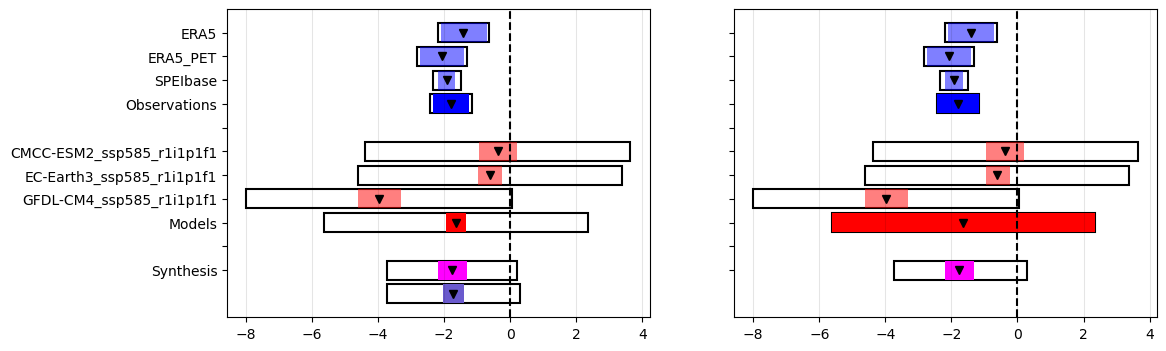

In [490]:
fig, axs = plt.subplots(ncols = 2, sharey = True, sharex = True, figsize = (12,4))

# can either print with the weighted & unweighted synthesis split out, and natural/representation uncertainty split
plot_synthesis(synthesis(obs_in, models_in, cx_format = False), ax = axs[0])

# or use the format that comes out of the Climate Explorer
plot_synthesis(synthesis(obs_in, models_in, cx_format = True), ax = axs[1])